# IBM Streams SPL Toolkits tutorial

This tutorial demonstrates how to discover, use, build and launch SPL toolkits in a Python notebook.

In this notebook, you'll see examples of how to:
1. [Setup](#setup)
2. [Discover Python packages](#discoverpypi)
3. [Discover toolkits](#discovertoolkits)
4. [Launch SPL main composite](#ghtksample)
5. [Work with a microservice of a toolkit](#ghtk)
6. [Integration of SPL operators in a Python topology](#splpy)

# Overview

**Introduction**

IBM Streams provides toolkits as reusable assets to get a solution faster.
The build service contains product "Out of the Box" toolkits and in addition you can use "Open Source" toolkits from GitHub (https://github.com/IBMStreams) and Customer developed toolkits.
Many product toolkits are open source toolkits. This tutorial shows how to find them and how to check for updates.

You will also learn in this tutorial, how to use SPL operators in the Python API, and how to work with existing SPL application like samples and microservices.

**How it works**
   
The Python applications created in this notebook are submitted to the IBM Streams service for execution.

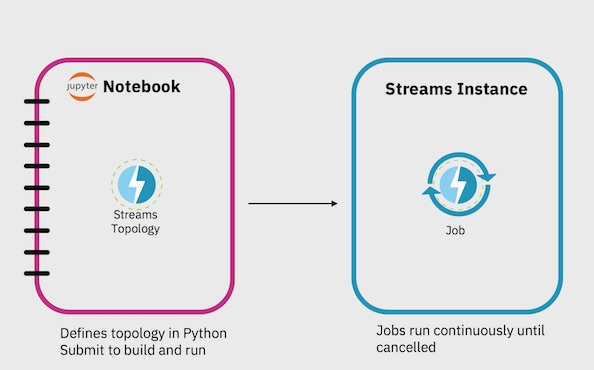


## Documentation
    
- [Streams Python development guide](https://ibmstreams.github.io/streamsx.documentation/docs/latest/python/)
- [Streams Python API](https://streamsxtopology.readthedocs.io/)



## <a name="setup"> </a> 1. Setup

### 1.1 Add credentials for the IBM Streams service

In order to submit a Streams application you need to provide the name of the Streams instance.

1. From the navigation menu, click **Services > Instances**.
2. Update the value of `streams_instance_name` in the cell below according to your Streams instance name.

In [ ]:
from icpd_core import icpd_util
streams_instance_name = "sample-streams" ## Change this to Streams instance
try:
    cfg=icpd_util.get_service_instance_details(name=streams_instance_name, instance_type="streams")
except TypeError:
    cfg=icpd_util.get_service_instance_details(name=streams_instance_name)

   ### 1.2 Import  the `streamsx.toolkits` package and verify the package version

In [ ]:
import streamsx.toolkits as tkutils
print("INFO: streamsx.toolkits package version: " + tkutils.__version__)

## <a name="discoverpypi"> </a> 2. Discover Python packages

### 2.1 Discover installed Python packages

In [ ]:
installed_packages = tkutils.get_installed_packages()
print (installed_packages)

### 2.2 Discover latest version of Python packages on pypi.org

In [ ]:
pypi_packages = tkutils.get_pypi_packages()
print (pypi_packages)

### 2.3 Check for updates of Python packages

In [ ]:
from colorama import Fore, Back, Style

for x in pypi_packages:
    if x in installed_packages:
        if installed_packages[x] != pypi_packages[x]:
            print(Style.BRIGHT + Fore.BLACK + 'NEW VERSION ' + x 
                  + ': ' + Back.GREEN + pypi_packages[x] + Back.RESET)
    else:
        print(Fore.RED + 'NEW PACKAGE ' + x + ': ' + pypi_packages[x])

### 2.4 Optional: Upgrade the Python package

Uncomment and change the name `<NAME>` of the package name in the cell below.
Run the cell below if you want to upgrade to the latest version of package.


In [ ]:
#import sys
#!{sys.executable} -m pip install --user --upgrade streamsx.<NAME>

## <a name="discovertoolkits"> </a> 3. Discover Toolkits

### 3.1 Retrieve a list of toolkits available on the Streams build service

This contains all product toolkits and custom toolkits that have been uploaded to the build service

In [ ]:
build_service_toolkits = tkutils.get_build_service_toolkits(cfg)
print(build_service_toolkits)

### 3.2 Retrieve a list of product toolkits on GitHub

In [ ]:
github_toolkits = tkutils.get_github_toolkits()
print(github_toolkits)

### 3.3 Check for toolkit updates

In [ ]:
from colorama import Fore, Back, Style

for x in github_toolkits:
    if x in build_service_toolkits:
        if build_service_toolkits[x] < github_toolkits[x]:
            print(Style.BRIGHT + Fore.BLACK + 'NEW VERSION ' + x
                  + ': ' + Back.GREEN + github_toolkits[x] + Back.RESET)
    else:
        print(Fore.RED + 'NEW TOOLKIT ' + x + ': ' + github_toolkits[x])

In order to use a newer version of a toolkit, you can download the toolkit from GitHub with the function
`streamsx.toolkits.download_toolkit()` described here: https://streamsxtoolkits.readthedocs.io/en/latest/

You can also upload a toolkit to the build service: https://streamsxtopology.readthedocs.io/en/stable/streamsx.build.html

## <a name="ghtksample"> </a> 4. Launch SPL main composite

This sample uses a toolkit from GitHub.
* Downloads the toolkit
* Selects a sample application as main composite
* Builds and launches the application to the Streams instance 

### 4.1 Download the toolkit from GitHub

In [ ]:
nlp_tk = tkutils.download_toolkit('com.ibm.streamsx.nlp')

Download samples directory from repository

In [ ]:
nlp_samples = tkutils.download_toolkit('samples', repository_name='streamsx.nlp')

List the samples directory

In [ ]:
!ls $nlp_samples

### 4.2 Select the sample application
**Hint:** The main composite must be defined as `public composite <composite name>` to be used as a topology.

In [ ]:
sample_app = nlp_samples + '/LemmatizerSample'
main_composite_name = 'nlp.sample::LemmatizerSample'

import streamsx.spl.op as op
# here it is important, to include also the application, here 'sample_app', into the toolkits list:
r = op.main_composite(kind=main_composite_name, toolkits=[sample_app, nlp_tk])
# 'r' is a tuple containing the resulting Topology, and an Invoke of the main composite
topo = r[0]

### 4.3. Submit the application

A running Streams application is called a *job*. This next cell submits the application for execution and prints the resulting job id.

In [ ]:
from streamsx.topology import context

# Disable SSL certificate verification if necessary
cfg[context.ConfigParams.SSL_VERIFY] = False

submission_result = context.submit(context.ContextTypes.DISTRIBUTED,
                                   topo, 
                                   config=cfg)
# The submission_result object contains information about the running application, or job
if submission_result.job:
    print("JobId: ", submission_result.job.id , "Name: ", submission_result.job.name)

### 4.4 See job status

You can view job status and logs by going to Projects > Jobs. Find your job based on the name printed above. Retrieve job logs using the "Download logs" action from the job's context menu.

To view other information about the job such as detailed metrics, access the graph. Go to **Projects** > **Jobs**. Select "View graph" action for the running job.


### 4.5 Cancel the job

The Streams job is running in the Streams service. You can cancel it within the notebook or delete it from **Projects** > **Jobs**.

In [ ]:
# cancel the job directly using the Job object
submission_result.job.cancel()

## Summary

We launched an existing SPL application with the Python API.

## <a name="ghtk"> </a> 5. Work with a microservice of a toolkit

This sample uses a toolkit from GitHub. The microservice is a part of the toolkit.
* Downloads the toolkit
* Selects a microservice application as main composite
* Builds and launches the application to the Streams instance 
* Creates an application that uses the microservice.
  It ingest tuples to the microservice and to receive the resulting tuples from the microservice.

### 5.1 Download the toolkit from GitHub

In [ ]:
nlp_tk = tkutils.download_toolkit('com.ibm.streamsx.nlp')

### 5.2 Select the microservice application

The nlp toolkits provides one microservice called `UimaService` that processes UIMA PEAR file.

This microservice subscribes to the following topics.

* `streamsx/nlp/documents` - ingest topic of type String
* `streamsx/nlp/update/pear` - update pear topic of type String. String contains the filename of the pear file location.

The following topic is published by the microservice:
* `streamsx/nlp/annotations` - resulting annotations. Each tuple represents a processed document. Output is of type Json. CAS output is transformed to JSON and format depends on PEAR.

In [ ]:
nlp_microservice = 'com.ibm.streamsx.nlp.services::UimaService'

import streamsx.spl.op as op

r = op.main_composite(kind=nlp_microservice, toolkits=[nlp_tk])
topo_nlp_microservice = r[0]

### 5.3. Submit the microservice application

A running Streams application is called a *job*. This next cell submits the application for execution and prints the resulting job id.

In [ ]:
from streamsx.topology import context

# Disable SSL certificate verification if necessary
cfg[context.ConfigParams.SSL_VERIFY] = False

submission_result_microservice = context.submit(context.ContextTypes.DISTRIBUTED,
                                                topo_nlp_microservice,
                                                config=cfg)
# The submission_result object contains information about the running application, or job
if submission_result_microservice.job:
    print("JobId: ", submission_result_microservice.job.id , "Name: ", submission_result_microservice.job.name)

### 5.4. Create an application to connect to the microservice

This application generates documents to be processed by the "UimaService" and receives the output of the "UimaService".

In [ ]:
from streamsx.topology.topology import Topology
from streamsx.topology.schema import CommonSchema
import time

class StringData(object):
    def __init__(self, count, delay=True):
        self.count = count
        self.delay = delay
    def __call__(self):
        if self.delay:
            time.sleep(10)
        doc = 'Text Sample\n'+'April 4, 2019 Distillery Lunch Seminar UIMA and its Metadata 12:00PM-1:00PM in HAW GN-K35 \n'+'April 16, 2019 KM & I Department Tea \n'+'Title: An Eclipse-based TAE Configurator Tool \n'+'3:00PM-4:30PM in HAW GN-K35 \n'+'May 11, 2019 UIMA Tutorial \n'+'9:00AM-5:00PM in HAW GN-K35 \n'
        for i in range(self.count):
            yield doc + ' - doc_' + str(i)

topo = Topology("NLPSample", namespace="sample")
s = topo.source(StringData(1000)).as_string()
s.publish("streamsx/nlp/documents", schema=CommonSchema.String)
    
ts = topo.subscribe("streamsx/nlp/annotations", schema=CommonSchema.Json)
ts.print()
ts.isolate()

### 5.5. Submit the application

A running Streams application is called a *job*. This next cell submits the application for execution and prints the resulting job id.

In [ ]:
from streamsx.topology import context

# Disable SSL certificate verification if necessary
cfg[context.ConfigParams.SSL_VERIFY] = False

submission_result_nlp_sample = context.submit(context.ContextTypes.DISTRIBUTED,
                                              topo, 
                                              config=cfg)
# The submission_result object contains information about the running application, or job
if submission_result_nlp_sample.job:
    print("JobId: ", submission_result_nlp_sample.job.id, "Name: ", submission_result_nlp_sample.job.name)

### 5.6 See job status

You can view job status and logs by going to Projects > Jobs. Find your job based on the name printed above. Retrieve job logs using the "Download logs" action from the job's context menu.

To view other information about the job such as detailed metrics, access the graph. Go to **Projects** > **Jobs**. Select "View graph" action for the running job.


### 5.7 Cancel the jobs

The Streams jobs are running in the Streams service. You can cancel them within the notebook or delete them from **Projects** > **Jobs**.

In [ ]:
# cancel the job in the IBM Streams service
submission_result_nlp_sample.job.cancel()

# cancel the microservice job in the IBM Streams service
submission_result_microservice.job.cancel()

## Summary

We launched an application with the Python API that works as microservice. We created an application to connect to this microservice with `publish` and `subsribe`.

## <a name="splpy"> </a> 6. Integration of SPL operators


Integration of SPL operators:
https://ibmstreams.github.io/streamsx.topology/doc/pythondoc/streamsx.spl.op.html#


### 6.1 Download the 'com.ibm.streamsx.nlp' toolkit

In [ ]:
nlp_tk = tkutils.download_toolkit('com.ibm.streamsx.nlp')

### 6.2 Create sample application using SPL primitive operators

In [ ]:
topo_spl = Topology("WrapSPLOperatorsSample", namespace="sample")

In this example we are using a `Beacon` as source operator, which produces an infinite stream of tuples with the text *The cow jumps over the moon*.


    stream<rstring document> Beacon = spl.utility::Beacon() {
        param
            initDelay: 5.0;
            period: 0.01;
        output Beacon: document="The cow jumps over the moon";
    }


In [ ]:
import streamsx.spl.op as op

# Beacon operator is used to generate tuples with a single attribute of type rstring
pulse = op.Source(topo_spl, kind='spl.utility::Beacon',
                  schema='tuple<rstring document>',
                  params={'initDelay': 5.0, 'period': 0.01})
# output clause for the 'document' attribute of the output schema definition
pulse.document = pulse.output('"The cow jumps over the moon"')

Invoke operator (one input stream and one output stream)

In SPL the invocation of the NgramBasic operator would look like below:
		
        stream<map<rstring, uint32> ngramMap> NgramBasic = com.ibm.streamsx.nlp::NgramBasic (Beacon) {
        	param
				documentAttribute: 'document';
				size: 3u;
				minSize: 1u;
			output NgramBasic: ngramMap = NgramCount();
		}

In [ ]:
from streamsx.spl.types import uint32
from streamsx.spl.toolkit import add_toolkit

ngrams = op.Invoke(topo_spl,
                   inputs = [pulse.stream],
                   kind = "com.ibm.streamsx.nlp::NgramBasic",
                   schemas = 'tuple<map<rstring, uint32> ngramMap>',
                   params = {'documentAttribute': 'document'})
# there are different ways to specify operator parameters: use the params argument in the Invoke,
# or use the params attribute of the resulting Invoke object:
ngrams.params['size'] = uint32(3)
ngrams.params['minSize'] = uint32(1)
# assign the NgramCount() function to the 'ngramMap' attribute of the output stream 0:
ngrams.ngramMap = ngrams.output(ngrams.outputs[0], 'NgramCount()')

# Dump output stream to console log
ngrams.outputs[0].print()

add_toolkit(topo_spl, nlp_tk)

### 6.3 Submit the application

A running Streams application is called a *job*. This next cell submits the application for execution and prints the resulting job id.

In [ ]:
from streamsx.topology import context

# Disable SSL certificate verification if necessary
cfg[context.ConfigParams.SSL_VERIFY] = False

submission_result_spl_sample = context.submit(context.ContextTypes.DISTRIBUTED,
                                              topo_spl, 
                                              config=cfg)
# The submission_result object contains information about the running application, or job
if submission_result_spl_sample.job:
    print("JobId: ", submission_result_spl_sample.job.id, "Name: ", submission_result_spl_sample.job.name)

### 6.4 See job status

You can view job status and logs by going to Projects > Jobs. Find your job based on the name printed above. Retrieve job logs using the "Download logs" action from the job's context menu.

To view other information about the job such as detailed metrics, access the graph. Go to **Projects** > **Jobs**. Select "View graph" for the running job.


### 6.5 Cancel the job

The Streams job is running in the Streams service. You can cancel it within the notebook or delete it from **Projects** > **Jobs**.

In [ ]:
# cancel the job directly using the Job object
submission_result_spl_sample.job.cancel()

## Summary

We used SPL operators with the Python Topology API.